# Objective : Predict the medical insurance premium for individuals based upon their demographics and health profiles.

### Load and inspect the data

In [ ]:
import pandas as pd
premium= pd.read_csv("Medicalpremium.csv")

In [5]:
print(premium.head())

   Age  Diabetes  BloodPressureProblems  AnyTransplants  AnyChronicDiseases  \
0   45         0                      0               0                   0   
1   60         1                      0               0                   0   
2   36         1                      1               0                   0   
3   52         1                      1               0                   1   
4   38         0                      0               0                   1   

   Height  Weight  KnownAllergies  HistoryOfCancerInFamily  \
0     155      57               0                        0   
1     180      73               0                        0   
2     158      59               0                        0   
3     183      93               0                        0   
4     166      88               0                        0   

   NumberOfMajorSurgeries  PremiumPrice  
0                       0         25000  
1                       0         29000  
2                       1 

In [7]:
print(premium.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      986 non-null    int64
 1   Diabetes                 986 non-null    int64
 2   BloodPressureProblems    986 non-null    int64
 3   AnyTransplants           986 non-null    int64
 4   AnyChronicDiseases       986 non-null    int64
 5   Height                   986 non-null    int64
 6   Weight                   986 non-null    int64
 7   KnownAllergies           986 non-null    int64
 8   HistoryOfCancerInFamily  986 non-null    int64
 9   NumberOfMajorSurgeries   986 non-null    int64
 10  PremiumPrice             986 non-null    int64
dtypes: int64(11)
memory usage: 84.9 KB
None


In [9]:
print(premium.describe(include= 'all'))

              Age    Diabetes  BloodPressureProblems  AnyTransplants  \
count  986.000000  986.000000             986.000000      986.000000   
mean    41.745436    0.419878               0.468560        0.055781   
std     13.963371    0.493789               0.499264        0.229615   
min     18.000000    0.000000               0.000000        0.000000   
25%     30.000000    0.000000               0.000000        0.000000   
50%     42.000000    0.000000               0.000000        0.000000   
75%     53.000000    1.000000               1.000000        0.000000   
max     66.000000    1.000000               1.000000        1.000000   

       AnyChronicDiseases      Height      Weight  KnownAllergies  \
count          986.000000  986.000000  986.000000      986.000000   
mean             0.180527  168.182556   76.950304        0.215010   
std              0.384821   10.098155   14.265096        0.411038   
min              0.000000  145.000000   51.000000        0.000000   
25%   

#### Data looks ok with no null values, nothing looks like an outliers but lets further do analysis.

### Exploratory data analysis

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

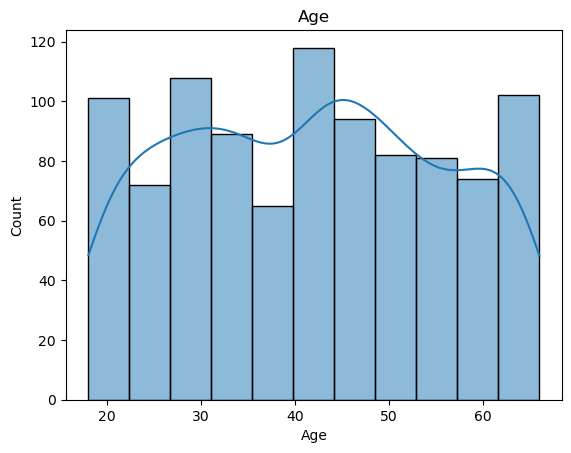

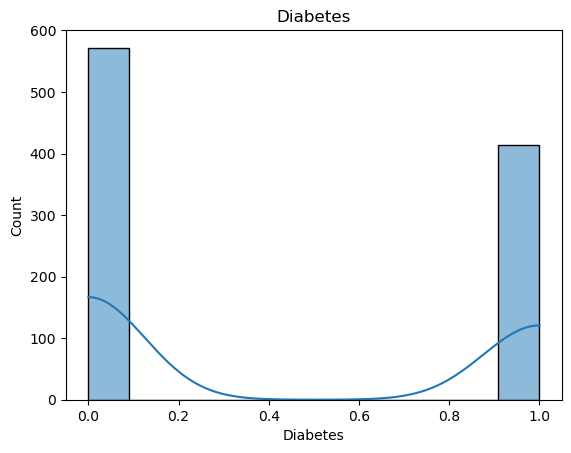

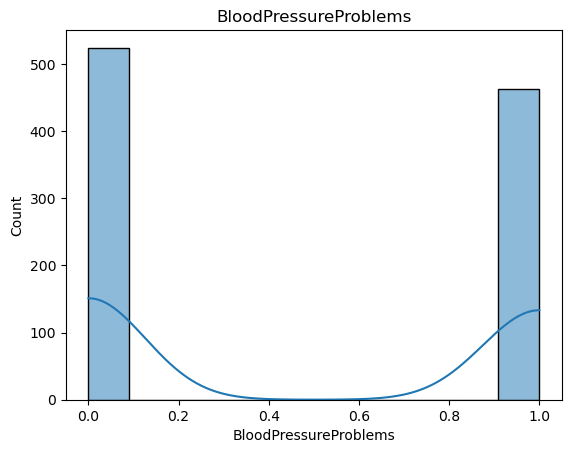

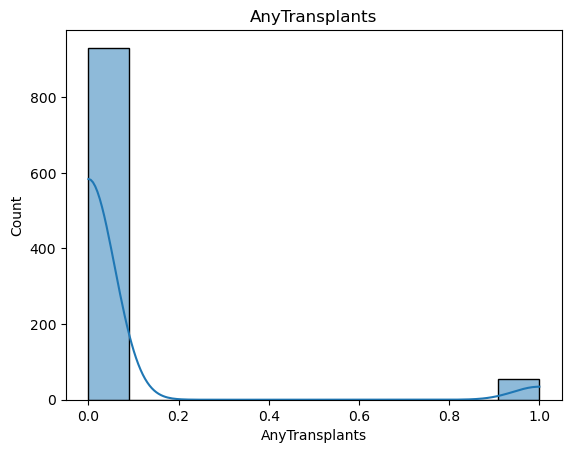

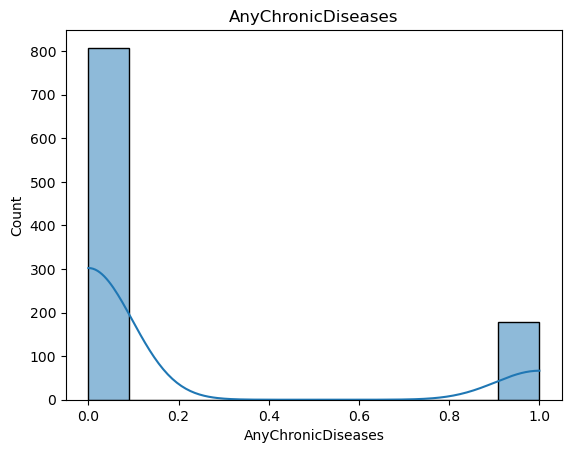

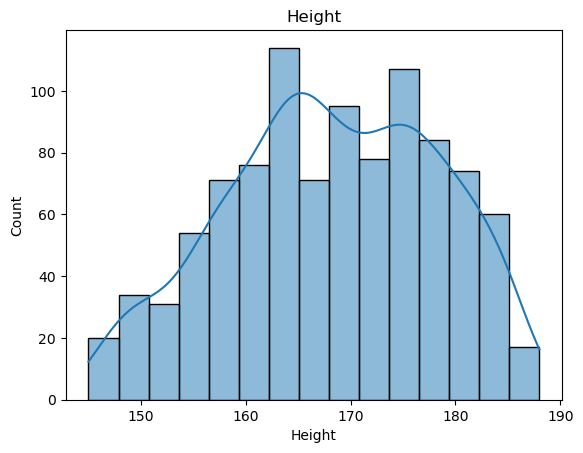

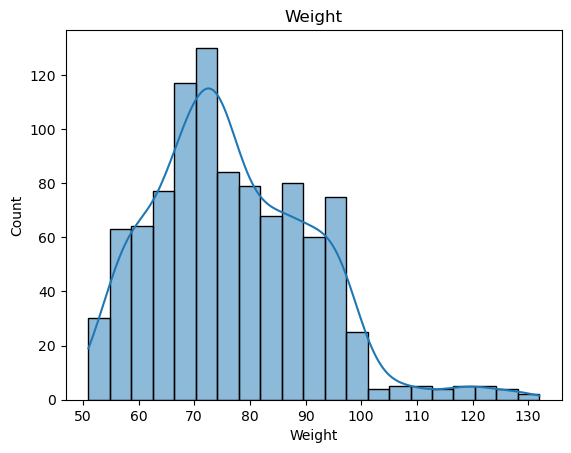

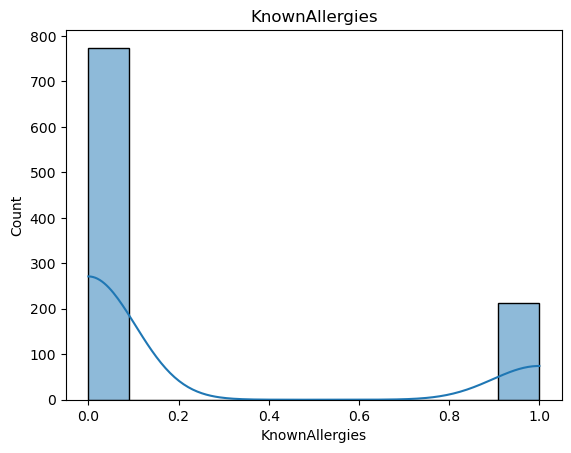

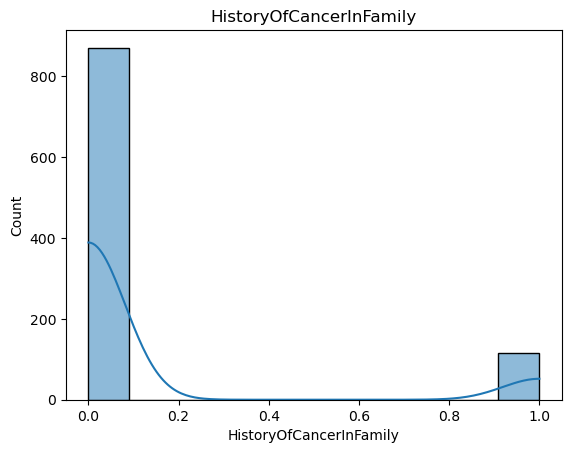

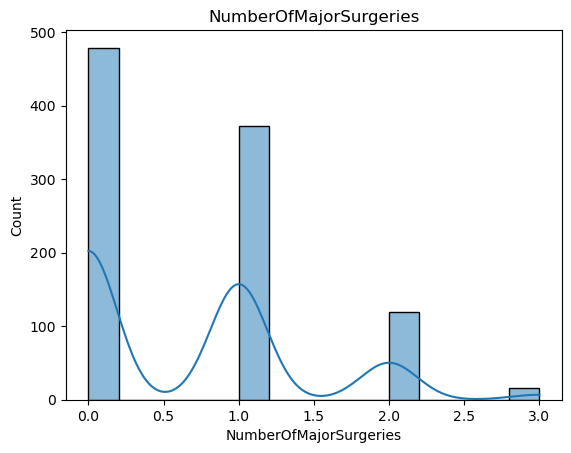

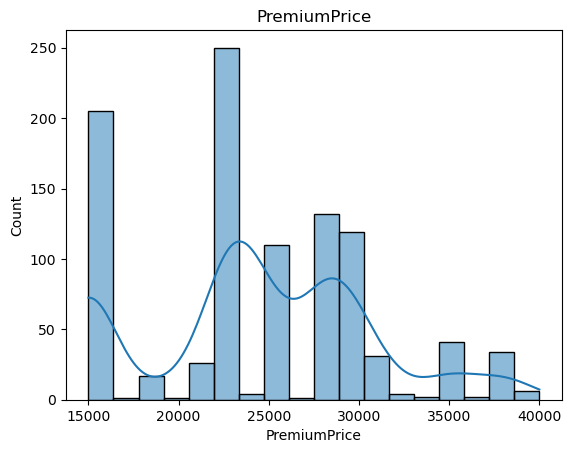

In [19]:
#since every column is numerical in nature we can do a histplot to check the distribution
#univariate analysis
for col in premium.select_dtypes(include = 'number').columns:
    sns.histplot(premium[col], kde= True)
    plt.title(col)
    plt.show()

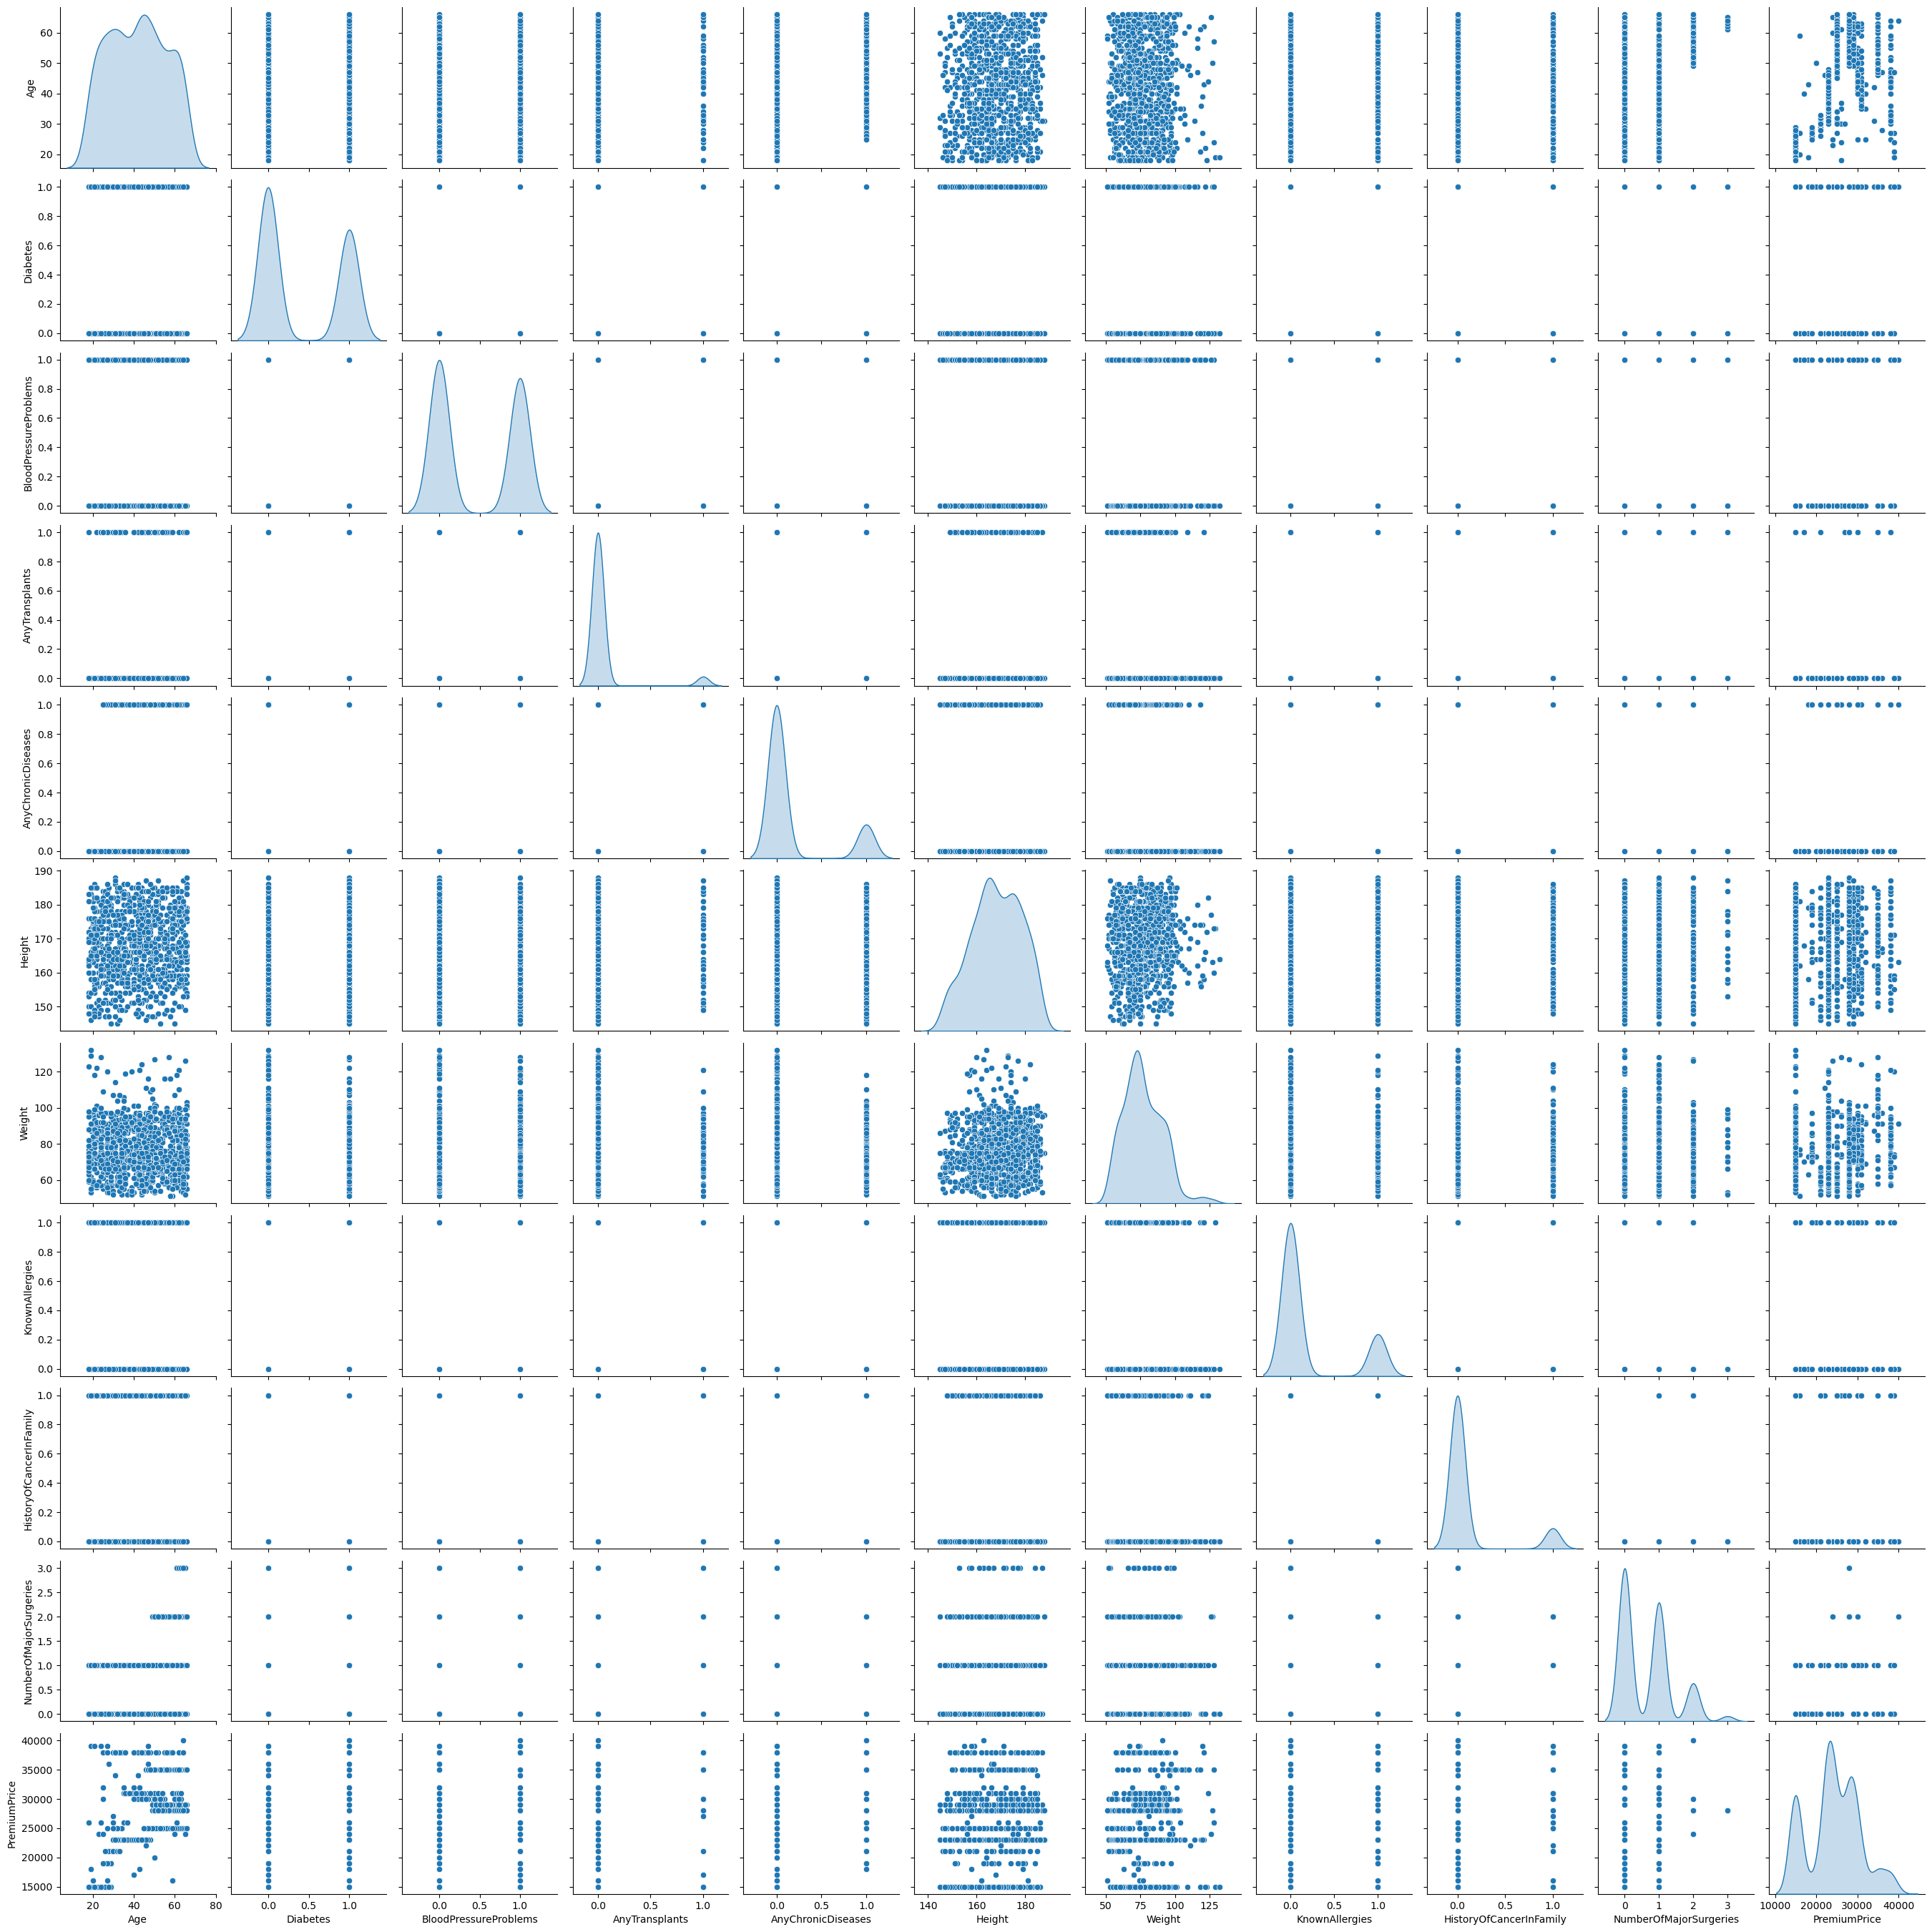

In [23]:
#Bivariate analysis
sns.pairplot(premium, diag_kind= 'kde')

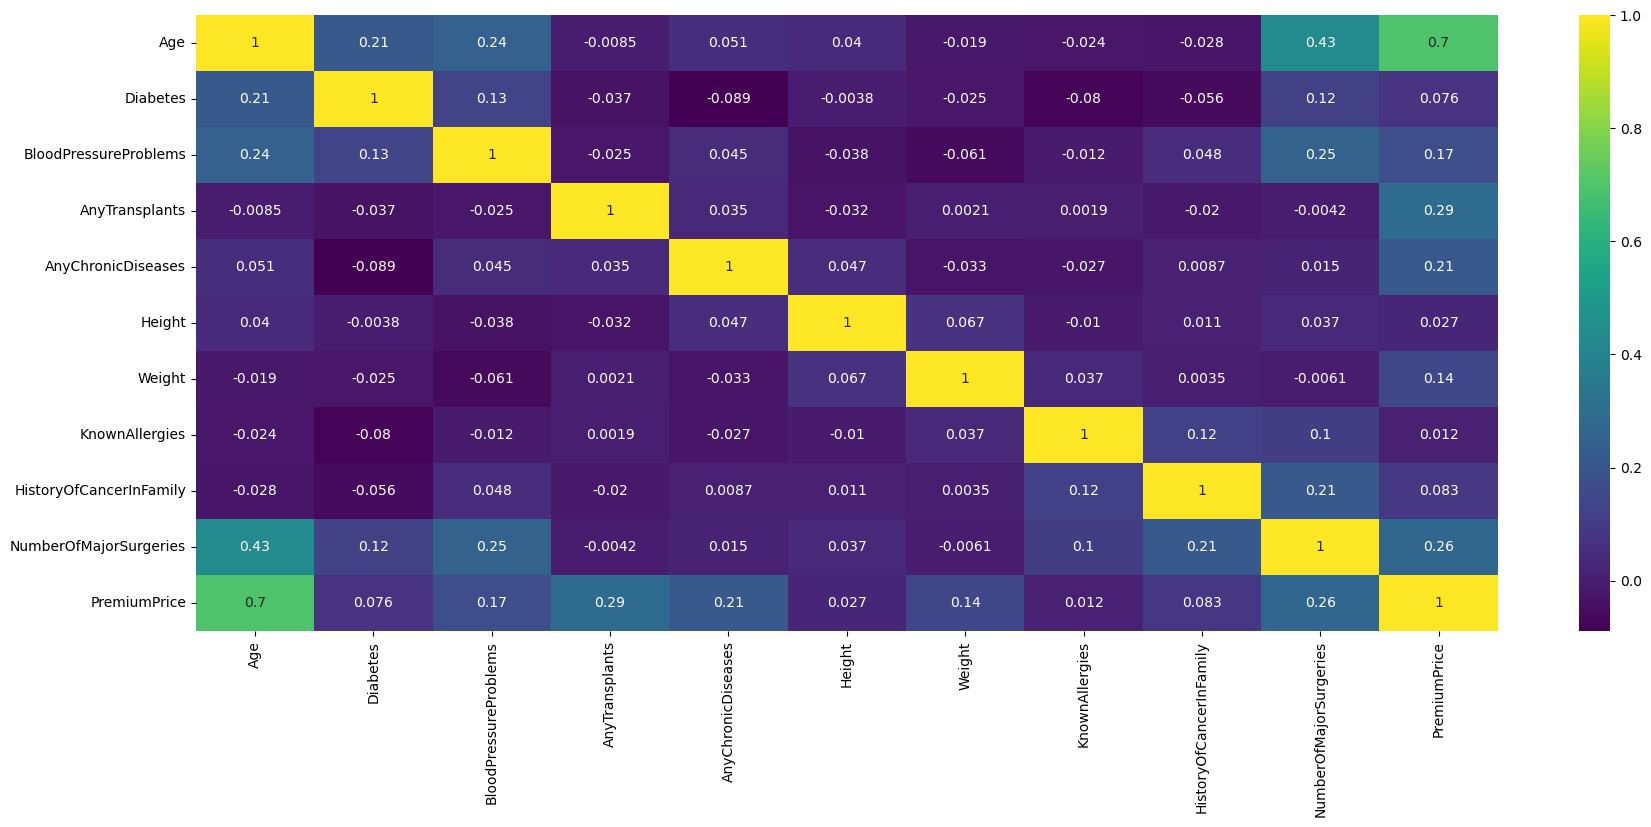

In [27]:
plt.figure(figsize=(21,8))
sns.heatmap(premium.corr(), annot= True, cmap= "viridis")
plt.show()

In [29]:
premium.columns

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice'],
      dtype='object')

In [31]:
#dropping col with very less corelation
premium.drop(columns=['KnownAllergies', 'Height'], inplace= True)

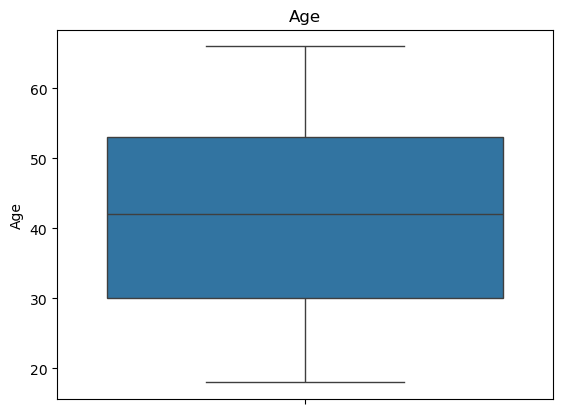

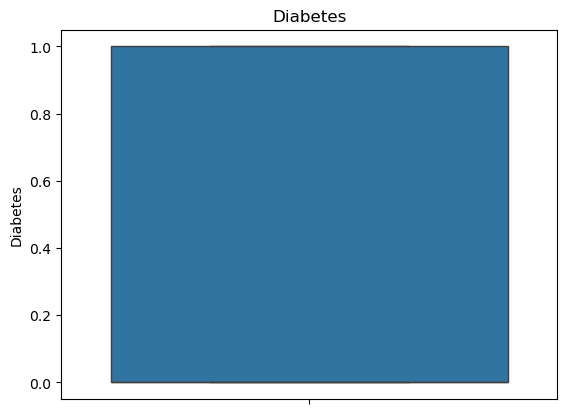

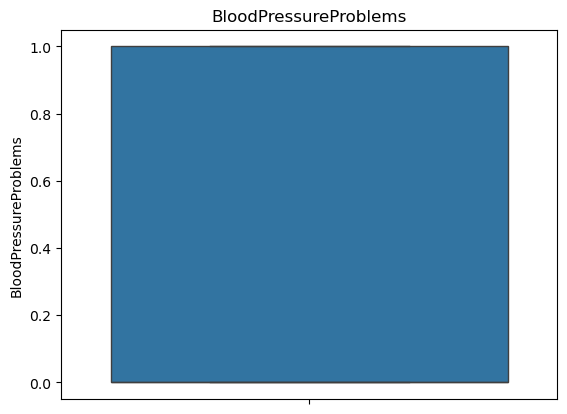

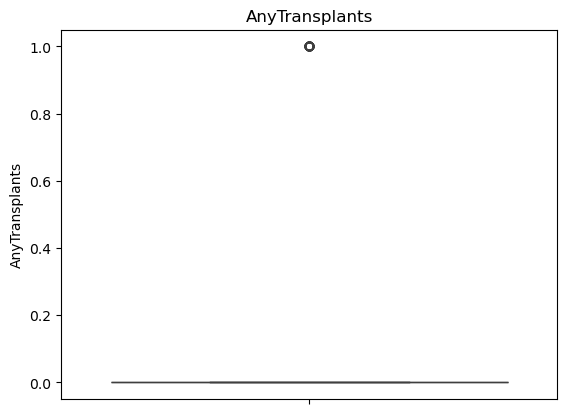

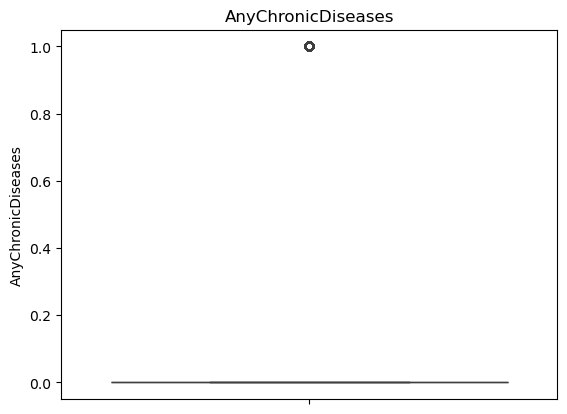

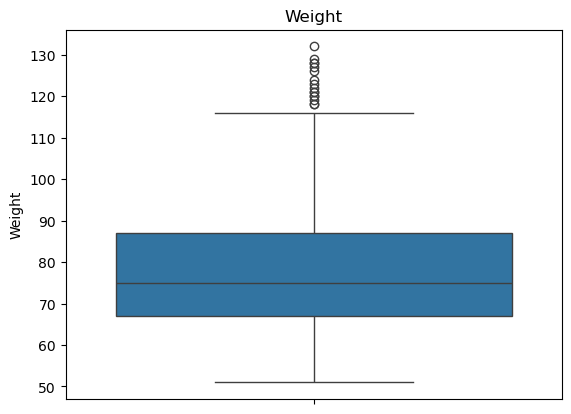

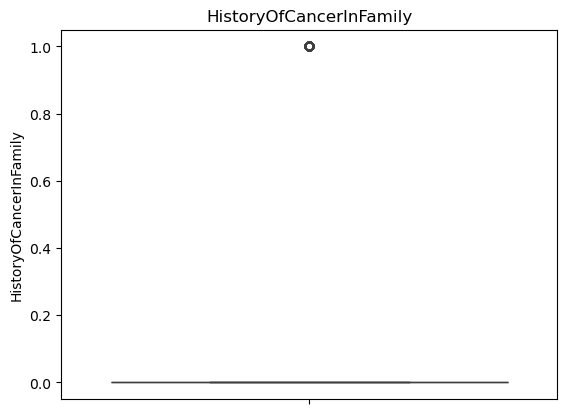

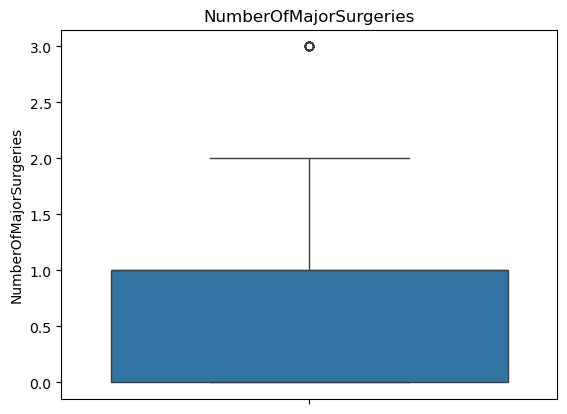

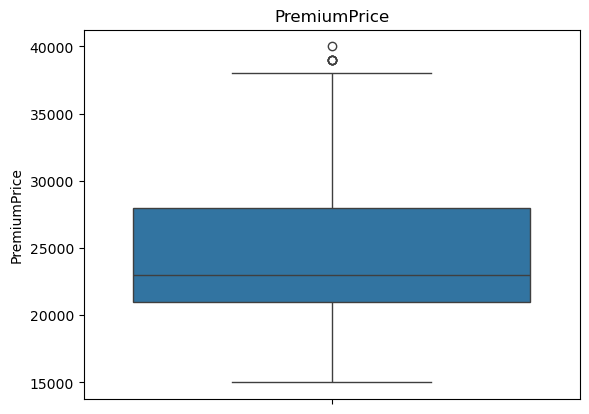

In [33]:
for col in premium.select_dtypes(include= 'number'):
    sns.boxplot(premium[col])
    plt.title(col)
    plt.show()

#### Here also everything looks ok

### Feature selection

In [41]:
#multicolinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = premium.drop('PremiumPrice', axis = 1)
X_const = add_constant(X)

vif = pd.DataFrame()
vif['Features']= X_const.columns
vif['VIF']= [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print(vif)

                  Features        VIF
0                    const  41.020514
1                      Age   1.316114
2                 Diabetes   1.071447
3    BloodPressureProblems   1.107298
4           AnyTransplants   1.003419
5       AnyChronicDiseases   1.017487
6                   Weight   1.005237
7  HistoryOfCancerInFamily   1.071888
8   NumberOfMajorSurgeries   1.342645


#### Here also the vif of all the columns look ok except const but 
> The const column is a column of all 1s — it has no variance, so it’s perfectly "correlated" with the mean of your predictors in a mathematical sense.

> VIF is not meaningful for the intercept. It often returns a very high number or even inf.

In [48]:
# RFE : Recursive feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()

rfe= RFE(model, n_features_to_select= 8)
rfe.fit(X, premium['PremiumPrice'])

selected = X.columns[rfe.support_]
print(selected)

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Weight', 'HistoryOfCancerInFamily',
       'NumberOfMajorSurgeries'],
      dtype='object')


#### Here I'm selecting all the columns since none is multicolinear , but  we will drop any column if its p-value > 0.05

### Train-Test split

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, premium['PremiumPrice'], train_size= 0.7)

### Train the model

In [58]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)
linear_model = sm.OLS(y_train, X_train_sm).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           PremiumPrice   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     149.0
Date:                Sat, 10 May 2025   Prob (F-statistic):          4.14e-144
Time:                        17:06:28   Log-Likelihood:                -6652.7
No. Observations:                 690   AIC:                         1.332e+04
Df Residuals:                     681   BIC:                         1.336e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    3950.7666    935.547      4.223      0.000    2113.864    5787.669
Age                       326.8591     11.773     27.762      0.000     303.743     349.976
Diabetes                 -524.2076    297.656     -1.761      0.079   -1108.640      60.225
BloodPressureProblems     119.1224    299.418      0.398      0.691    -468.771     707.015
AnyTransplants           7550.7520    614.345     12.291      0.000    6344.514    8756.990
AnyChronicDiseases       2821.5653    373.614      7.552      0.000    2087.992    3555.139
Weight                     80.1324     10.304      7.777      0.000      59.902     100.363
HistoryOfCancerInFamily  2434.8604    450.891      5.400      0.000    1549.556    3320.165
NumberOfMajorSurgeries   -655.7172    215.241     -3.046      0.002   -1078.333    -233.102
==============================================================================
Omnibus:                       74.721   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.101
Skew:                           0.512   Prob(JB):                     2.94e-50
Kurtosis:                       5.624   Cond. No.                         586.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Here we can see that `BloodPressureProblems` is not relevant to this model so we are gonna drop it

In [61]:
X_train.drop(['BloodPressureProblems'], axis = 1, inplace= True)
X_test.drop(['BloodPressureProblems'], axis = 1, inplace= True)

In [63]:
#now again build the model
X_train_sm = sm.add_constant(X_train)
lr_model = sm.OLS(y_train, X_train_sm).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           PremiumPrice   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     170.5
Date:                Sat, 10 May 2025   Prob (F-statistic):          3.31e-145
Time:                        17:10:16   Log-Likelihood:                -6652.8
No. Observations:                 690   AIC:                         1.332e+04
Df Residuals:                     682   BIC:                         1.336e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    3979.9916    932.082      4.270      0.000    2149.896    5810.087
Age                       327.5013     11.655     28.099      0.000     304.617     350.385
Diabetes                 -520.3051    297.310     -1.750      0.081   -1104.058      63.448
AnyTransplants           7534.9320    612.678     12.298      0.000    6331.970    8737.894
AnyChronicDiseases       2822.3573    373.378      7.559      0.000    2089.249    3555.465
Weight                     79.9850     10.291      7.773      0.000      59.780     100.190
HistoryOfCancerInFamily  2440.6653    450.377      5.419      0.000    1556.373    3324.957
NumberOfMajorSurgeries   -642.2879    212.446     -3.023      0.003   -1059.415    -225.161
==============================================================================
Omnibus:                       76.335   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.434
Skew:                           0.521   Prob(JB):                     7.52e-52
Kurtosis:                       5.665   Cond. No.                         584.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### We did not drop `Diabetes` earlier because its not good to drop two columns together but now also we can see that the Diabetes has very less relevance so we are gonna drop it

In [66]:
X_train.drop(['Diabetes'], axis = 1, inplace= True)
X_test.drop(['Diabetes'], axis = 1, inplace= True)

In [68]:
#train the model one last time
X_train_sm = sm.add_constant(X_train)
lr_model = sm.OLS(y_train, X_train_sm).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           PremiumPrice   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     197.8
Date:                Sat, 10 May 2025   Prob (F-statistic):          1.03e-145
Time:                        17:13:28   Log-Likelihood:                -6654.3
No. Observations:                 690   AIC:                         1.332e+04
Df Residuals:                     683   BIC:                         1.335e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    3899.5616    932.353      4.182      0.000    2068.939    5730.185
Age                       324.0748     11.507     28.164      0.000     301.482     346.668
AnyTransplants           7569.2214    613.289     12.342      0.000    6365.064    8773.379
AnyChronicDiseases       2893.6143    371.711      7.785      0.000    2163.781    3623.448
Weight                     79.8261     10.306      7.746      0.000      59.591     100.061
HistoryOfCancerInFamily  2508.2560    449.395      5.581      0.000    1625.895    3390.617
NumberOfMajorSurgeries   -657.4396    212.590     -3.093      0.002   -1074.848    -240.031
==============================================================================
Omnibus:                       76.126   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.685
Skew:                           0.519   Prob(JB):                     6.63e-52
Kurtosis:                       5.669   Cond. No.                         583.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
lr_model.params

const                      3899.561584
Age                         324.074777
AnyTransplants             7569.221447
AnyChronicDiseases         2893.614294
Weight                       79.826090
HistoryOfCancerInFamily    2508.256000
NumberOfMajorSurgeries     -657.439612
dtype: float64

## 📈 Linear Regression Model: Premium Price Estimation

\begin{align*}
\text{PremiumPrice} =\ & 3899.56 \\
& +\ 324.07 \times \text{Age} \\
& +\ 7569.22 \times \text{AnyTransplants} \\
& +\ 2893.61 \times \text{AnyChronicDiseases} \\
& +\ 79.83 \times \text{Weight} \\
& +\ 2508.26 \times \text{HistoryOfCancerInFamily} \\
& -\ 657.44 \times \text{NumberOfMajorSurgeries}
\end{align*}

### Predict using the test set and Model Evaluation

In [83]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

X_test_sm = sm.add_constant(X_test)
y_pred = lr_model.predict(X_test_sm)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2 score: {r2_score(y_test, y_pred)}')

MAE: 2507.6063484099554
RMSE: 3775.6122573441016
R2 score: 0.6475138472626234


### Model Assumptions check

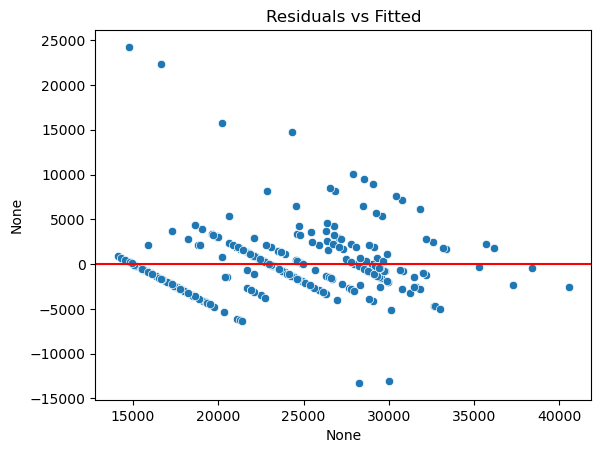

In [87]:
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red')
plt.title("Residuals vs Fitted")
plt.show()

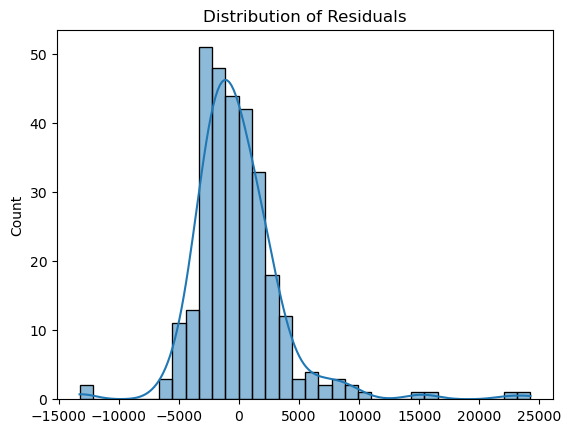

In [89]:
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.show()

## 📈 Linear Regression Model Evaluation Summary

**Evaluation Metrics:**

| Metric   | Value        | Interpretation |
|----------|--------------|----------------|
| **MAE**  | ₹2,507.61    | Average prediction error. Indicates typical absolute deviation. |
| **RMSE** | ₹3,775.61    | Penalizes larger errors more. Slightly higher than MAE, suggesting some large errors exist. |
| **R²**   | 0.6475       | Explains ~65% of variance in premium prices. Decent, but room for improvement. |

---

### ✅ Verdict:
- Model is **moderately good** for estimating medical premiums.
- Good for **basic use**, but may not be suitable for **critical financial decisions**.
- Further tuning, feature selection, or model upgrades (e.g., Ridge/Lasso) can enhance accuracy.

